In [1]:
path = "/home/sourav/cra"

Simulation study. Several iterations of data generated, CRA estimated, double robustness proof. 

In [2]:
import sys, os
sys.path.append(os.path.abspath("..")) 
from src.simulator import generate_data
from src.estimator import cra_estimator
from src.states import *
from src.policy import *

import os, sys
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

In [3]:
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="sklearn.linear_model._logistic"
)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

warnings.filterwarnings("ignore", category=FutureWarning)

In [19]:
# simulation parameters
N_MC = 400          # Monte Carlo iterations
n = 1000             # individuals
T = 4               # time steps
p = 4               # state variables
k = 3               # actions

# feature subsets for misspecification
features_full = [f"Z{i+1}" for i in range(p)]
features_miss1 = ["Z1", "Z2"]   # drop some features for outcome misspecification
features_miss2 = ["Z3", "Z4"]   # drop some features for propensity misspecification

In [15]:
results = []
for seed in trange(N_MC, desc="Monte Carlo runs", leave=False):
    df = generate_data(n=n, T=T, p=p, k=k, seed=seed)
    theta_correct, _ = cra_estimator(df, features_full, k=k)
    theta_m_miss, _ = cra_estimator(df, features_miss1, k=k)
    theta_e_miss, _ = cra_estimator(df, features_miss2, k=k)
    theta_both_miss, _ = cra_estimator(df, ["Z1"], k=k)
    for a in range(k):
        results.extend([
            {"seed": seed, "action": a, "scenario": "correct", "estimate": theta_correct[a]},
            {"seed": seed, "action": a, "scenario": "m_miss", "estimate": theta_m_miss[a]},
            {"seed": seed, "action": a, "scenario": "e_miss", "estimate": theta_e_miss[a]},
            {"seed": seed, "action": a, "scenario": "both_miss", "estimate": theta_both_miss[a]}
        ])
print("Monte Carlo complete.");

Monte Carlo complete.


In [16]:
df_results = pd.DataFrame(results)
df_results.head()
os.makedirs("../data", exist_ok=True)
save_path = "../data/simulation_results_cra.csv"
df_results.to_csv(save_path, index=False)
print(f"Monte Carlo results saved to {save_path}")

Monte Carlo results saved to ../data/simulation_results_cra.csv


In [17]:
#box plots
df_results = pd.read_csv("../data/simulation_results_cra.csv")

# compute the average CRA estimate when both models are correct
ref_means = (
    df_results.query("scenario == 'correct'")
    .groupby("action")["estimate"]
    .mean()
    .to_dict()
)
print("Ground-truth (CRA-correct) means:", ref_means)

Ground-truth (CRA-correct) means: {0: -0.012551898000009085, 1: -0.013256763908197005, 2: -0.012552404355309578}


In [18]:
scenarios_to_plot = ["m_miss", "e_miss", "both_miss"]
df_plot = df_results[df_results["scenario"].isin(scenarios_to_plot)]

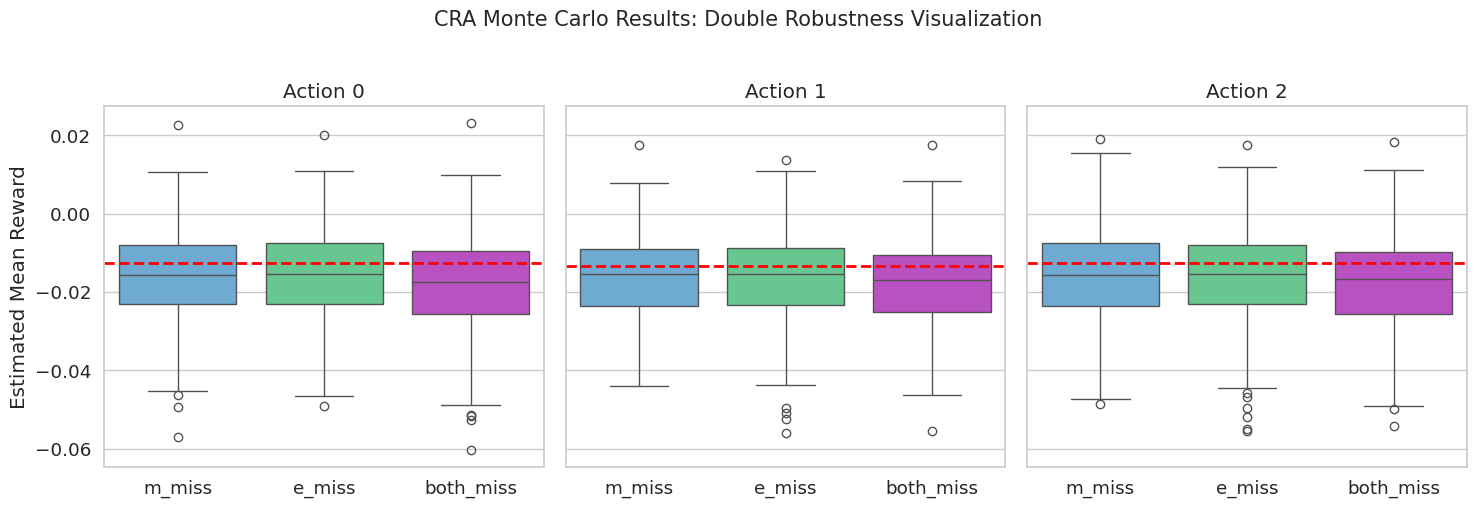

In [19]:
sns.set_theme(style="whitegrid", font_scale=1.2)
actions = sorted(df_plot["action"].unique())

fig, axes = plt.subplots(1, len(actions), figsize=(15, 5), sharey=True)

for idx, a in enumerate(actions):
    ax = axes[idx]
    subset = df_plot[df_plot["action"] == a]
    sns.boxplot(
    data=subset,
    x="scenario",
    y="estimate",
    hue="scenario",
    ax=ax,
    order=["m_miss", "e_miss", "both_miss"],
    palette=["#5DADE2", "#58D68D", "#C83ED492"],
    legend=False
)
    # add horizontal line for CRA-correct reference
    ax.axhline(y=ref_means[a], color="red", linestyle="--", linewidth=2)
    ax.set_title(f"Action {a}")
    ax.set_xlabel("")
    if idx == 0:
        ax.set_ylabel("Estimated Mean Reward")
    else:
        ax.set_ylabel("")

plt.suptitle("CRA Monte Carlo Results: Double Robustness Visualization", fontsize=15, y=1.02)
plt.tight_layout()
#fig.set_size_inches(18, 6)
plt.savefig(os.path.join(path, "plots/cra_results.png"), dpi=400, bbox_inches="tight")
plt.show()

In [20]:
summary = df_plot.groupby(["action","scenario"])["estimate"].agg(['mean','std'])
print(summary)

                      mean       std
action scenario                     
0      both_miss -0.017869  0.012045
       e_miss    -0.015827  0.011163
       m_miss    -0.015999  0.011713
1      both_miss -0.018073  0.011441
       e_miss    -0.016324  0.011305
       m_miss    -0.016333  0.011133
2      both_miss -0.017558  0.012010
       e_miss    -0.015897  0.011701
       m_miss    -0.015892  0.011795


In [4]:
def make_feature_sets(p, drop_frac=0.5, seed = 0):
    features_full = [f"Z{i+1}" for i in range(p)]

    num_drop = int(p * drop_frac)
    num_drop = max(1, num_drop)

    # drop the FIRST num_drop features deterministically
    dropped = features_full[:num_drop]
    kept    = features_full[num_drop:]

    # outcome misspecified: m drops, e full
    features_miss_outcome    = kept

    # propensity misspecified: m full, e drops
    features_miss_propensity = kept

    # both misspecified: both drop same subset
    features_both_outcome    = kept
    features_both_propensity = kept

    return (
        features_full,
        features_miss_outcome,
        features_miss_propensity,
        (features_both_outcome, features_both_propensity)
    )

In [ ]:
def run_single_simulation(n, T, p, k, N_MC, seed0):

    rng = np.random.default_rng(seed0)

    # FIXED stats for this environment
    stats = get_stats_subset(p)

    # FIXED policy parameters
    alphas, betas = generate_policy_parameters(p, k, seed0)

    # FIXED transition matrices
    phi = np.eye(p) * rng.uniform(0.97, 1.03, size=p) \
        + rng.uniform(-0.02, 0.02, size=(p, p)) #off diagonal
    psi = rng.uniform(-0.02, 0.02, size=(p, k))

    # FIXED reward weights
    # w = rng.uniform(0.1, 1.0, size=p)
    # w = w / w.sum()
    w = np.ones(p)/p

    # FIXED misspecification configuration
    features_full, features_miss_outcome, features_miss_propensity, (features_both_outcome, features_both_propensity) = \
        make_feature_sets(p=p, seed=seed0)

    records = []

    for s in trange(N_MC, leave=False):
        seed = seed0 + s

        df = generate_data(
            n=n, T=T, p=p, k=k,
            stats=stats,
            alphas=alphas,
            betas=betas,
            phi=phi,
            psi=psi,
            w=w,
            seed=seed
        )

        theta_correct, _ = cra_estimator(df,
                              features_outcome    = features_full,
                              features_propensity = features_full,
                              k=k)

        theta_m_miss, _  = cra_estimator(df,
                              features_outcome    = features_miss_outcome,
                              features_propensity = features_full,
                              k=k)

        theta_e_miss, _  = cra_estimator(df,
                              features_outcome    = features_full,
                              features_propensity = features_miss_propensity,
                              k=k)

        theta_both_miss, _ = cra_estimator(df,
                                features_outcome    = features_both_outcome,
                                features_propensity = features_both_propensity,
                                k=k)

        for a in range(k):
            records.extend([
                {"seed": seed, "action": a, "scenario": "correct",   "estimate": theta_correct[a]},
                {"seed": seed, "action": a, "scenario": "m_miss",    "estimate": theta_m_miss[a]},
                {"seed": seed, "action": a, "scenario": "e_miss",    "estimate": theta_e_miss[a]},
                {"seed": seed, "action": a, "scenario": "both_miss", "estimate": theta_both_miss[a]},
            ])

    return pd.DataFrame(records)

In [24]:
def compute_delta(df):
    correct = df[df["scenario"]=="correct"][["seed","action","estimate"]] \
        .rename(columns={"estimate":"est_correct"})
    merged = df.merge(correct, on=["seed","action"])
    merged["delta"] = merged["estimate"] - merged["est_correct"]
    return merged

def run_sweep(param_name, values, fixed, N_MC, seed0, outdir):
    outputs = {}
    for v in values:
        cfg = fixed.copy()
        cfg[param_name] = v
        df = run_single_simulation(
            n=cfg["n"],
            T=cfg["T"],
            p=cfg["p"],
            k=cfg["k"],
            N_MC=N_MC,
            seed0=seed0
        )
        df = compute_delta(df)
        path = f"{outdir}/{param_name}_{v}.csv"
        df.to_csv(path, index=False)
        outputs[v] = path
    return outputs

def run_all():
    baseline = {"n":1000, "T":5, "p":10, "k":3}

    N_MC = 1000
    seed0 = 1234
    outdir = "../data/sims"

    base_df = run_single_simulation(**baseline, N_MC=N_MC, seed0=seed0)
    base_df = compute_delta(base_df)
    base_df.to_csv(f"{outdir}/baseline.csv", index=False) #n = 1000
    # run_sweep("n", [500, 2000, 5000], baseline, N_MC, seed0, outdir) 
    # run_sweep("n", [5000], baseline, N_MC, seed0, outdir) 
    # run_sweep("T", [2,5,10], baseline, N_MC, seed0, outdir) 
    # run_sweep("p", [4, 6, 10], baseline, N_MC, seed0, outdir)
    run_sweep("k", [3, 4, 5], baseline, N_MC, seed0, outdir)

In [25]:
run_all()

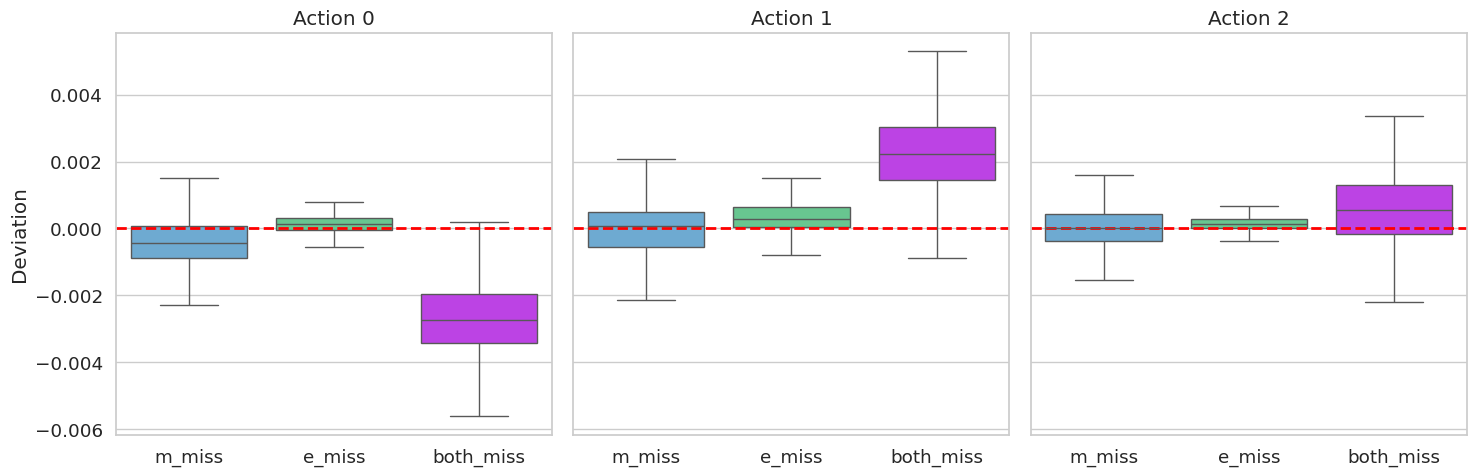

In [ ]:
df = pd.read_csv("../data/sims/T_2.csv")
df_plot = df[df["scenario"].isin(["m_miss","e_miss","both_miss"])]
sns.set_theme(style="whitegrid", font_scale=1.2)

actions = sorted(df_plot["action"].unique())
fig, axes = plt.subplots(1, len(actions), figsize=(15,5), sharey=True)

for idx, a in enumerate(actions):
    ax = axes[idx]
    subset = df_plot[df_plot["action"] == a]

    sns.boxplot(
        data=subset,
        x="scenario",
        y="delta",
        order=["m_miss","e_miss","both_miss"],
        palette=["#5DADE2","#58D68D","#C928FF"],
        ax=ax,
        showfliers=False
    )

    ax.axhline(0, color="red", linestyle="--", linewidth=2)

    ax.set_title(f"Action {a}")
    ax.set_xlabel("")
    #ax.set_ylim(-0.002, 0.002)
    if idx == 0:
        ax.set_ylabel("Deviation")
    else:
        ax.set_ylabel("")

plt.tight_layout()
#plt.savefig(os.path.join(path, "plots/cra_n_250.png"), dpi=400, bbox_inches="tight")
plt.show()

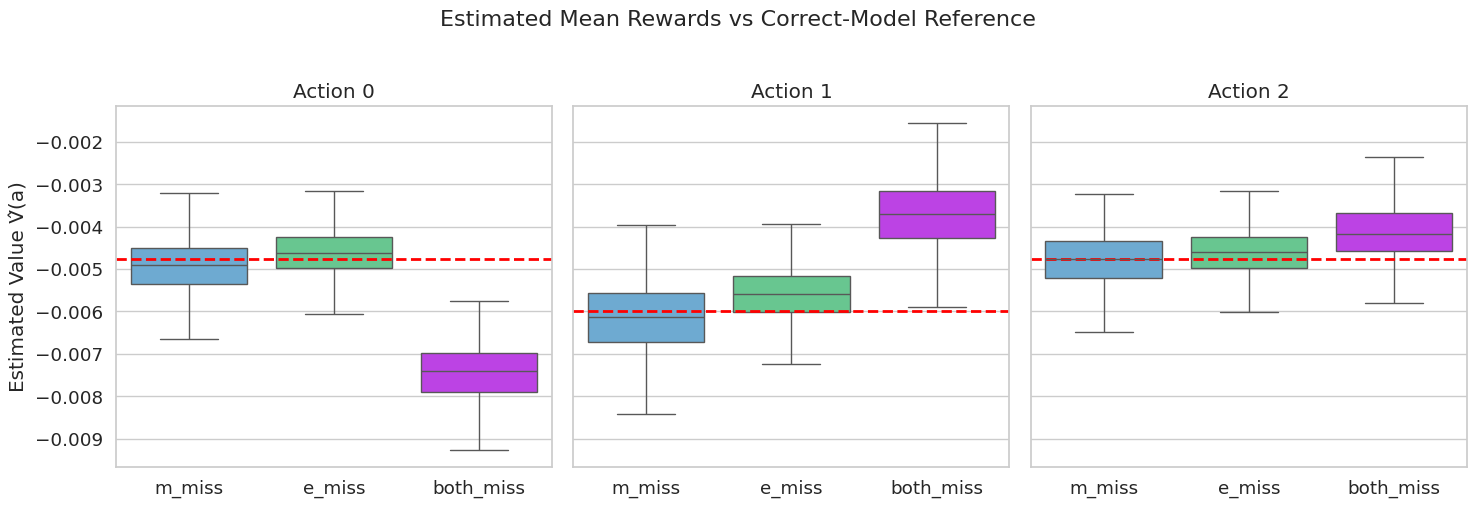

In [39]:


# ------------------------------------------------------------
# 1. Load simulation results
# ------------------------------------------------------------
df = pd.read_csv("../data/sims/baseline.csv")

# df contains:
# seed, action, scenario, estimate, est_correct, delta

# ------------------------------------------------------------
# 2. Extract correct-model mean per action
# ------------------------------------------------------------
correct_means = (
    df[df["scenario"] == "correct"]
    .groupby("action")["estimate"]
    .mean()
    .to_dict()
)

# ------------------------------------------------------------
# 3. Filter to only the misspecification scenarios
# ------------------------------------------------------------
df_plot = df[df["scenario"].isin(["m_miss", "e_miss", "both_miss"])]

# ------------------------------------------------------------
# 4. Plot raw estimates with horizontal correct-mean line
# ------------------------------------------------------------
sns.set_theme(style="whitegrid", font_scale=1.2)

actions = sorted(df_plot["action"].unique())
fig, axes = plt.subplots(1, len(actions), figsize=(15, 5), sharey=True)

for idx, a in enumerate(actions):
    ax = axes[idx]
    subset = df_plot[df_plot["action"] == a]

    sns.boxplot(
        data=subset,
        x="scenario",
        y="estimate",
        order=["m_miss", "e_miss", "both_miss"],
        palette=["#5DADE2", "#58D68D", "#C928FF"],
        ax=ax,
        showfliers=False
    )

    # Correct-model reference line
    ax.axhline(correct_means[a], color="red", linestyle="--", linewidth=2)

    ax.set_title(f"Action {a}")
    ax.set_xlabel("")
    if idx == 0:
        ax.set_ylabel("Estimated Value V̂(a)")
    else:
        ax.set_ylabel("")

plt.suptitle("Estimated Mean Rewards vs Correct-Model Reference", fontsize=16, y=1.02)
plt.tight_layout()

plt.show()

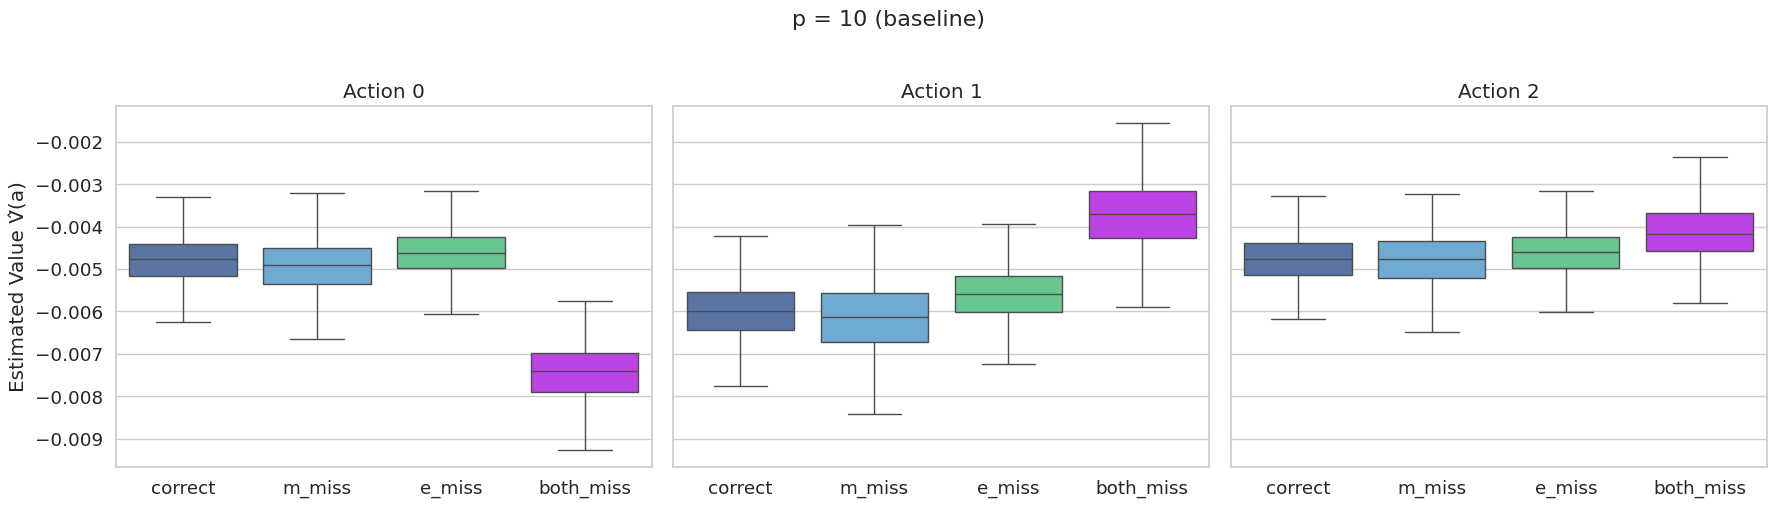

In [31]:
# ------------------------------------------------------------
# 1. Load results
# ------------------------------------------------------------
df = pd.read_csv("../data/sims/p_10.csv")

# ------------------------------------------------------------
# 2. Subset to the four scenarios
# ------------------------------------------------------------
scenarios = ["correct", "m_miss", "e_miss", "both_miss"]
df_plot = df[df["scenario"].isin(scenarios)]

# Ensure ordering in plot
scenario_order = ["correct", "m_miss", "e_miss", "both_miss"]

# ------------------------------------------------------------
# 3. Plot the four boxplots per action
# ------------------------------------------------------------
sns.set_theme(style="whitegrid", font_scale=1.2)

actions = sorted(df_plot["action"].unique())
fig, axes = plt.subplots(1, len(actions), figsize=(18, 5), sharey=True)

for idx, a in enumerate(actions):
    ax = axes[idx]
    subset = df_plot[df_plot["action"] == a]

    sns.boxplot(
        data=subset,
        x="scenario",
        y="estimate",
        order=scenario_order,
        palette=["#4C72B0", "#5DADE2", "#58D68D", "#C928FF"],
        ax=ax,
        showfliers=False
    )

    ax.set_title(f"Action {a}")
    ax.set_xlabel("")
    if idx == 0:
        ax.set_ylabel("Estimated Value V̂(a)")
    else:
        ax.set_ylabel("")

plt.suptitle("p = 10 (baseline)", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(path, "plots/cra_p_10.png"), dpi=400, bbox_inches="tight")
plt.show()